# Section: Thông tin nhóm
- Trần Kim Ngọc Ngân - 22520002
- Nguyễn Duy Thắng - 22521333


# Section: Kết nối với GoogleDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Section: Thêm thư viện

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [3]:
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import json
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [5]:
from IPython import display

In [6]:
# Thêm đường dẫn
dir_project = '/content/drive/MyDrive/CV'
dir_data = '/content/drive/MyDrive/CV/yoga-posture-dataset'
dir_dataset = '/content/drive/MyDrive/CV/dataset'
dir_test = '/content/drive/MyDrive/CV/test'
dir_pose_name = '/content/drive/MyDrive/CV/Poses.json'
test_link = '/content/drive/MyDrive/CV/yoga-posture-dataset/Sivasana/File15.jpeg'

# Section: Prepare Dataset

## Define some funtions

In [7]:
# !pip install opendatasets
# import opendatasets as od

# od.download('https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset')

# !mv /content/yoga-posture-dataset /content/drive/MyDrive/CV

In [8]:
# Đổi tên tiếng Ấn Độ sang tên Tiếng Anh
with open(dir_pose_name) as file:
    data = json.load(file)

name = dict()
id = dict()
print(data['Poses'])
for pose in data['Poses']:
  name[pose['sanskrit_name']] = pose['english_name']
  id[pose['sanskrit_name']] = pose['id']


[{'id': 1, 'sanskrit_name': 'Navasana', 'english_name': 'Boat', 'img_url': 'https://www.dropbox.com/s/4m64ztxkj8a4dab/boatstraightlegs.svg?raw=1'}, {'id': 2, 'sanskrit_name': 'Ardha Navasana', 'english_name': 'Half-Boat', 'img_url': 'https://www.dropbox.com/s/1nx0r94msxjwvyp/boatbentlegs.svg?raw=1'}, {'id': 3, 'sanskrit_name': 'Dhanurasana', 'english_name': 'Bow', 'img_url': 'https://www.dropbox.com/s/wizj5kwxvez4c0a/bow.svg?raw=1'}, {'id': 4, 'sanskrit_name': 'Setu Bandha Sarvangasana', 'english_name': 'Bridge', 'img_url': 'https://www.dropbox.com/s/f1w64ybg4sn8ejt/bridge.svg?raw=1'}, {'id': 5, 'sanskrit_name': 'Baddha Konasana', 'english_name': 'Butterfly', 'img_url': 'https://www.dropbox.com/s/3h2pts6xbn28dh7/butterfly%3F.svg?raw=1'}, {'id': 6, 'sanskrit_name': 'Ustrasana', 'english_name': 'Camel', 'img_url': 'https://www.dropbox.com/s/o5gr4lngltsdg5r/camel.svg?raw=1'}, {'id': 7, 'sanskrit_name': 'Marjaryasana', 'english_name': 'Cat', 'img_url': 'https://www.dropbox.com/s/cginnz98of

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


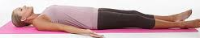

In [9]:
def visualize(image, detection_result) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  MARGIN = 10  # pixels
  ROW_SIZE = 10  # pixels
  FONT_SIZE = 1
  FONT_THICKNESS = 1
  TEXT_COLOR = (255, 0, 0)  # red
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)
    cv2.circle(image, (bbox.origin_x, bbox.origin_y),5, (0,0,255), -1)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

# Object detection
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# Funtion to detect person
def detect_person(img_path):
  image = mp.Image.create_from_file(img_path)
  detection_result = detector.detect(image)

  image = cv2.imread(img_path)

  if len(detection_result.detections) > 0:
    bbox = detection_result.detections[0].bounding_box
    x, y = bbox.origin_x, bbox.origin_y

    image = image[y:y+bbox.height, x:x+bbox.width]
    aspect_ratio = image.shape[1] / image.shape[0]
    image = cv2.resize(image, (200, int(200 / aspect_ratio)))

    return True, image
  else:
    return False, image

cv2_imshow(detect_person(test_link)[1])

## Make dataset

In [10]:
# for pose in os.listdir(dir_data):
#   ID = id[pose]
#   print(name[pose], end=" (")
#   print(ID, end="), ")

#   save_folder = os.path.join(dir_project,'dataset', name[pose])
#   if os.path.exists(save_folder):
#     print("Thư mục đã tồn tại")
#   else:
#     os.makedirs(save_folder)

#   img_folder = os.path.join(dir_data, pose)
#   for img_name in os.listdir(img_folder):

#     img_path = os.path.join(img_folder, img_name)
#     image = cv2.imread(img_path)
#     print(name[pose], end=", ")
#     print(ID, end=", ")
#     print(img_name, end=", ")
#     print(image.shape)
#     if image.shape[2] == 2:
#       continue

#     ok, image = detect_person(img_path)
#     if ok:
#       flipped_image = cv2.flip(image, 1)

#       cv2.imwrite(os.path.join(save_folder,img_name), image)
#       cv2.imwrite(os.path.join(save_folder,'(1)' + img_name), flipped_image)

#     display.clear_output(wait=True)


# Section: Load MediaPipe

In [11]:
mp_pose = mp.solutions.pose # instance detect pose
model = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

joints = ['nose',
          'right_eye', 'left_eye',
          'right_ear', 'left_ear',
          'right_wrist', 'left_wrist',
          'right_elbow', 'left_elbow',
          'right_shoulder', 'left_shoulder',
          'right_hip', 'left_hip',
          'right_knee', 'left_knee',
          'right_ankle', 'left_ankle']
# joints = ["nose", "right_eye_inner", "right_eye", "right_eye_outer", "left_eye_inner", "left_eye", "left_eye_outer",
#           "left_ear", "right_ear", "mouth_right", "mouth_left",
#           "right_shoulder", "left_shoulder", "right_elbow", "left_elbow",
#           "right_wrist", "left_wrist", "right_pinky", "left_pinky",
#           "right_index", "left_index", "right_thumb", "left_thumb",
#           "right_hip", "left_hip", "right_knee", "left_knee",
#           "right_ankle", "left_ankle", "right_heel", "left_heel",
#           "right_foot_index","left_foot_index"]



body_connections = [
    ('nose','right_eye'), ('nose', 'left_eye'),
    ('right_ear','right_eye'), ('left_ear', 'left_eye'),
    ('right_shoulder', 'left_shoulder'),
    ('right_shoulder','right_elbow'), ('left_shoulder','left_elbow'),
    ('right_elbow','right_wrist'), ('left_elbow','left_wrist'),
    ('right_hip', 'left_hip'),
    ('right_shoulder','right_hip'), ('left_shoulder','left_hip'),
    ('right_hip','right_knee'),('left_hip','left_knee'),
    ('right_knee','right_ankle'), ('left_knee','left_ankle')
]

def get_keypoints_MP(image_path):
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Xử lý hình ảnh bằng BlazePose
    results = model.process(image)

    specific_keypoints = {}
    if results.pose_landmarks:
        # specific_keypoints = {"nose": results.pose_landmarks.landmark[0],
        #                       "right_eye_inner": results.pose_landmarks.landmark[1],
        #                       "right_eye": results.pose_landmarks.landmark[2],
        #                       "right_eye_outer": results.pose_landmarks.landmark[3],
        #                       "left_eye_inner": results.pose_landmarks.landmark[4],
        #                       "left_eye": results.pose_landmarks.landmark[5],
        #                       "left_eye_outer": results.pose_landmarks.landmark[6],
        #                       "left_ear": results.pose_landmarks.landmark[7],
        #                       "right_ear": results.pose_landmarks.landmark[8],
        #                       "mouth_right": results.pose_landmarks.landmark[9],
        #                       "mouth_left": results.pose_landmarks.landmark[10],
        #                       "right_shoulder": results.pose_landmarks.landmark[11],
        #                       "left_shoulder": results.pose_landmarks.landmark[12],
        #                       "right_elbow": results.pose_landmarks.landmark[13],
        #                       "left_elbow": results.pose_landmarks.landmark[14],
        #                       "right_wrist": results.pose_landmarks.landmark[15],
        #                       "left_wrist": results.pose_landmarks.landmark[16],
        #                       "right_pinky": results.pose_landmarks.landmark[17],
        #                       "left_pinky": results.pose_landmarks.landmark[18],
        #                       "right_index": results.pose_landmarks.landmark[19],
        #                       "left_index": results.pose_landmarks.landmark[20],
        #                       "right_thumb": results.pose_landmarks.landmark[21],
        #                       "left_thumb": results.pose_landmarks.landmark[22],
        #                       "right_hip": results.pose_landmarks.landmark[23],
        #                       "left_hip": results.pose_landmarks.landmark[24],
        #                       "right_knee": results.pose_landmarks.landmark[25],
        #                       "left_knee": results.pose_landmarks.landmark[26],
        #                       "right_ankle": results.pose_landmarks.landmark[27],
        #                       "left_ankle": results.pose_landmarks.landmark[28],
        #                       "right_heel": results.pose_landmarks.landmark[29],
        #                       "left_heel": results.pose_landmarks.landmark[30],
        #                       "right_foot_index": results.pose_landmarks.landmark[31],
        #                       "left_foot_index": results.pose_landmarks.landmark[32]
        #                     }

        # Lấy tọa độ của các keypoints cần thiết
        specific_keypoints['nose'] = results.pose_landmarks.landmark[0]
        specific_keypoints['right_eye'] = results.pose_landmarks.landmark[2]
        specific_keypoints['left_eye'] = results.pose_landmarks.landmark[5]
        specific_keypoints['right_ear'] = results.pose_landmarks.landmark[7]
        specific_keypoints['left_ear'] = results.pose_landmarks.landmark[8]
        specific_keypoints['right_shoulder'] = results.pose_landmarks.landmark[11]
        specific_keypoints['left_shoulder'] = results.pose_landmarks.landmark[12]
        specific_keypoints['right_elbow'] = results.pose_landmarks.landmark[13]
        specific_keypoints['left_elbow'] = results.pose_landmarks.landmark[14]
        specific_keypoints['right_wrist'] = results.pose_landmarks.landmark[15]
        specific_keypoints['left_wrist'] = results.pose_landmarks.landmark[16]
        specific_keypoints['right_hip'] = results.pose_landmarks.landmark[23]
        specific_keypoints['left_hip'] = results.pose_landmarks.landmark[24]
        specific_keypoints['right_knee'] = results.pose_landmarks.landmark[25]
        specific_keypoints['left_knee'] = results.pose_landmarks.landmark[26]
        specific_keypoints['right_ankle'] = results.pose_landmarks.landmark[27]
        specific_keypoints['left_ankle'] = results.pose_landmarks.landmark[28]

    return specific_keypoints

# def draw_keypoint(img_path, keypoints, title=""):
#   # Vẽ các landmarks lên ảnh
#   image = cv2.imread(img_path)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   for j in joints:
#       h, w, c = image.shape
#       cx, cy = int(keypoints[j].x * w), int(keypoints[j].y * h)
#       cv2.circle(image, (cx, cy), 5, (255, 0, 0), -1)

#   for connection in body_connections:
#         index_A, index_B = connection
#         point_A = keypoints[index_A]
#         point_B = keypoints[index_B]
#         cv2.line(image, (int(point_A.x * w), int(point_A.y * h)), (int(point_B.x * w), int(point_B.y * h)), (0, 255, 0), 2)


#   # Hiển thị ảnh với các landmarks
#   plt.imshow(image)
#   plt.axis('off')  # Tắt trục tọa độ
#   plt.title(title)
#   plt.show()

# specific_keypoints = get_keypoints_MP(test_link)
# draw_keypoint(test_link, specific_keypoints)

# Section: Load dữ liệu

In [12]:
# data = {}
# for j in joints:
#   data[j + "_x"] = []
#   data[j + "_y"] = []
#   data[j + "_z"] = []
# data['label'] = []

# for pose in os.listdir(dir_dataset):
#   print(pose)
#   img_folder = os.path.join(dir_dataset, pose)
#   for img_name in os.listdir(img_folder):
#     img_path = os.path.join(img_folder, img_name)
#     keypoints = get_keypoints_MP(img_path)
#     if len(keypoints) != 0:
#       # image = cv2.imread(img_path)
#       # h, w, c = image.shape
#       for j in joints:
#         # if j in keypoints:
#         data[j + "_x"].append(keypoints[j].x)
#         data[j + "_y"].append(keypoints[j].y)
#         data[j + "_z"].append(keypoints[j].z)
#         # else:
#         #   data[j + "_x"].append(-1)
#         #   data[j + "_y"].append(-1)
#         #   # data[j + "_z"].append(-1)
#       data['label'].append(pose)
#   display.clear_output(wait=True)

# data_MP = pd.DataFrame(data)
# data_MP.to_csv(dir_project + '/feature/feature_all_3D.csv', index=False)
# data_MP

In [13]:
# Use for faster
data_MP = pd.read_csv(dir_project + '/feature/feature_points_2D.csv')

In [14]:
# Chia train - validation - test
X = data_MP.iloc[ : , : -1]
y = data_MP['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print(len(X_train))
print(len(X_val))
print(len(X_test))

2319
994
1421


# Section: Mô hình phân loại

## SVM

### Find the best degree

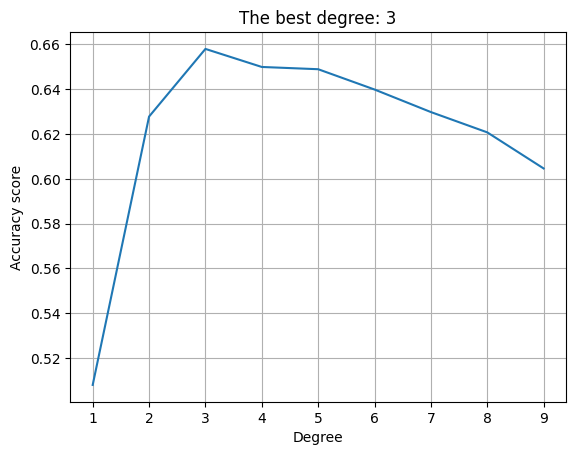

In [15]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=1.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

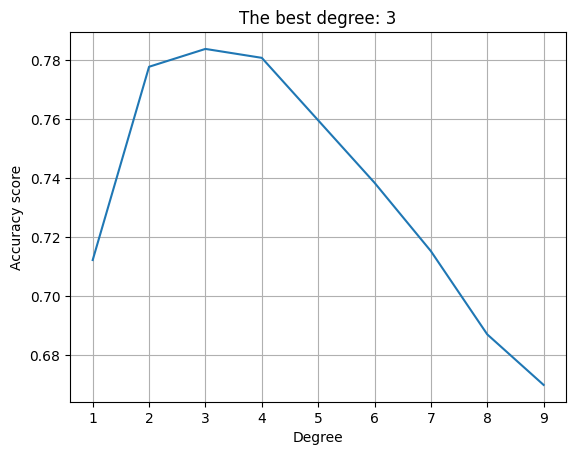

In [16]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=10.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

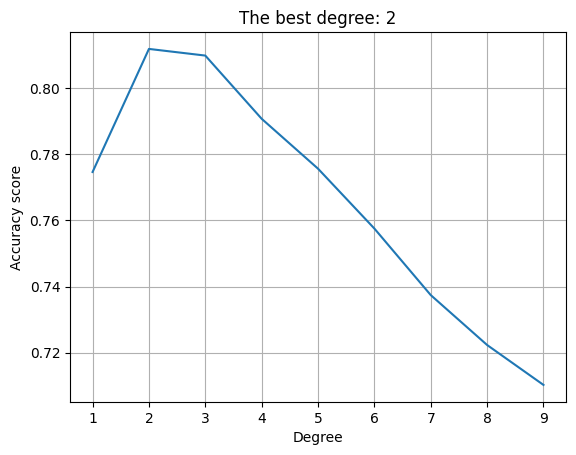

In [17]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=100.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

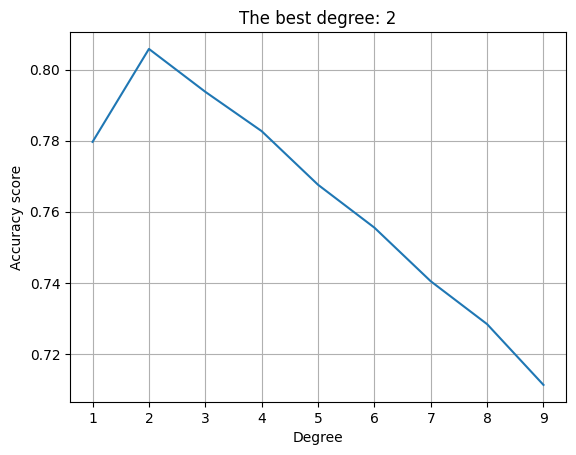

In [18]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=1000.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

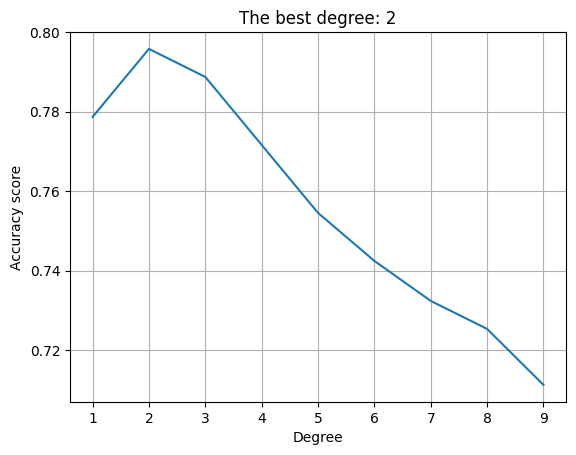

In [19]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=10000.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

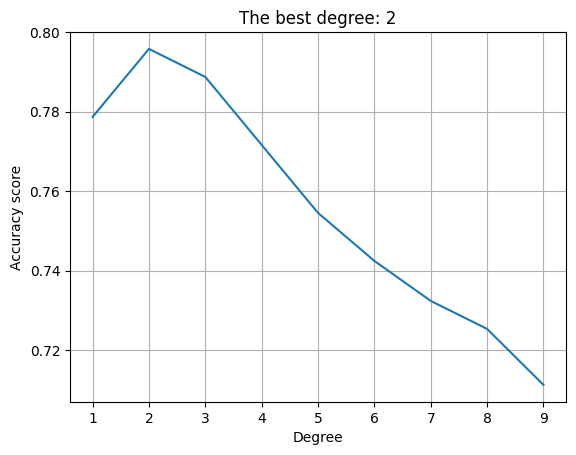

In [20]:
degree = range(1,10)
acc = []
for d in degree:
  svm = SVC(kernel="poly", degree=d, C=10000.0)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_d = acc.index(max(acc)) + 1

plt.plot(degree, acc)
plt.title('The best degree: ' + str(best_d))
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()

### Find the best Model

In [21]:
C = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ans = {'poly_2': [],
       'poly_3': [],
       'linear': [],
       'rbf': []}

for c in C:
  svm = SVC(kernel="poly", degree=2, C=c)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  ans['poly_2'].append(accuracy_score(y_val, y_pred))

  svm = SVC(kernel="poly", degree=3, C=c)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  ans['poly_3'].append(accuracy_score(y_val, y_pred))

  svm = SVC(kernel="linear", C=c)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  ans['linear'].append(accuracy_score(y_val, y_pred))

  svm = SVC(kernel="rbf", C=c)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_val)
  ans['rbf'].append(accuracy_score(y_val, y_pred))

df = pd.DataFrame(ans, index=C)
print(df)

max_value = df.max().max()
column_name = df.max().idxmax()
index_value = df[df[column_name] == max_value].index[0]
print("Optimal kernel: ",column_name)
print("Optimal C: ", index_value)


         poly_2    poly_3    linear       rbf
1      0.627767  0.657948  0.752515  0.669014
5      0.747485  0.761569  0.754527  0.760563
10     0.777666  0.783702  0.754527  0.786720
50     0.812877  0.803823  0.754527  0.812877
100    0.811871  0.809859  0.754527  0.816901
500    0.806841  0.802817  0.753521  0.815895
1000   0.805835  0.793763  0.753521  0.807847
5000   0.797787  0.788732  0.753521  0.799799
10000  0.795775  0.788732  0.753521  0.798793
Optimal kernel:  rbf
Optimal C:  100


## KNN

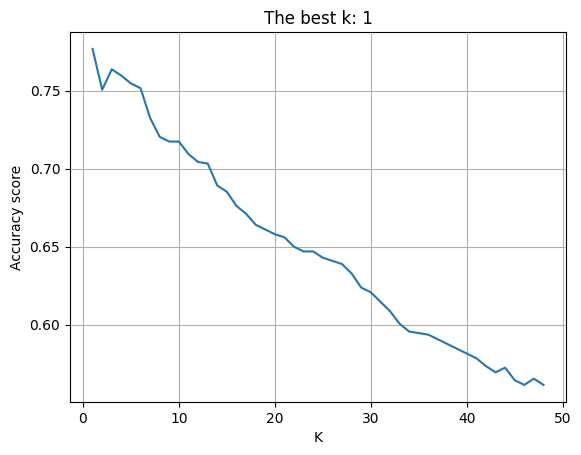

In [22]:
# KNN
K = range(1, len(os.listdir(dir_data))+2)
acc = []
for k in K:
  # Model, fit and predict
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_val)
  acc.append(accuracy_score(y_val, y_pred))

best_k = K[acc.index(max(acc))]

plt.plot(K, acc)
plt.title('The best k: ' + str(best_k))
plt.xlabel('K')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()


# Section: Đánh giá trên tập Test

In [23]:
# KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.8191414496833216

In [24]:
# SVM
svm = SVC(kernel="rbf", C=index_value)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.844475721323012

# Section: Minh hoạ

In [25]:
def make_input(img_path, label="hehe"):
  ok, image = detect_person(img_path)
  if ok:
    save_path = os.path.join(dir_test,"directly_test",label)
    cv2.imwrite(save_path, image)
  else:
    print("Can't detect person: " + label)

In [26]:
for img_name in os.listdir(dir_test):
  if img_name == "directly_test":
    continue
  make_input(img_path=os.path.join(dir_test,img_name), label=img_name)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [27]:
data = {}
for j in joints:
  data[j + "_x"] = []
  data[j + "_y"] = []
labels = []

for img_name in os.listdir(os.path.join(dir_test,"directly_test")):
  label = img_name.split('.')[0]
  labels.append(label)
  img_path = os.path.join(dir_test,"directly_test", img_name)
  keypoints = get_keypoints_MP(img_path)
  if len(keypoints) != 0:
    image = cv2.imread(img_path)
    h, w, c = image.shape
    for j in joints:
      data[j + "_x"].append(int(w*keypoints[j].x))
      data[j + "_y"].append(int(h*keypoints[j].y))
  else:
    print("Can't find keypoints:" + img_name)

data_test = pd.DataFrame(data)
data_test

,nose_x,nose_y,right_eye_x,right_eye_y,left_eye_x,left_eye_y,right_ear_x,right_ear_y,left_ear_x,left_ear_y,...,left_hip_x,left_hip_y,right_knee_x,right_knee_y,left_knee_x,left_knee_y,right_ankle_x,right_ankle_y,left_ankle_x,left_ankle_y
0,130,783,147,786,146,782,159,763,158,759,...,66,454,77,273,66,262,102,107,100,84
1,187,11,190,15,189,9,189,21,186,10,...,110,24,73,63,66,34,21,83,21,51
2,120,114,116,108,114,108,108,111,105,111,...,103,230,167,261,73,286,168,318,17,310
3,159,28,164,25,162,24,173,29,170,27,...,128,85,78,57,78,53,23,32,24,31
4,126,80,122,69,114,68,110,72,96,71,...,41,293,152,393,118,403,63,509,69,506
5,121,84,117,78,115,78,110,80,108,79,...,103,187,168,189,66,241,174,244,7,241
6,83,21,86,16,84,16,95,16,89,16,...,89,98,130,130,67,124,149,162,68,157
7,14,35,11,31,11,31,15,26,15,26,...,98,19,142,33,142,30,190,34,187,31
8,16,88,14,83,13,85,18,76,16,81,...,91,105,138,105,136,116,183,122,182,125
9,130,783,147,786,146,782,159,763,158,759,...,66,454,77,273,66,262,102,107,100,84


In [28]:
y_pred = svm.predict(data_test)
for i in range(9):
  print(labels[i], end=" - ")
  print(y_pred[i])

Handstand - Handstand
Corpse - Corpse
Cresent Lunge - Warrior One
Boat - Boat
Eagle - Eagle
Low Lunge - Warrior One
Warrior Two - Warrior Two
Plank - Plank
Side Plank - Side Plank


True label: Handstand - Predict label: Handstand


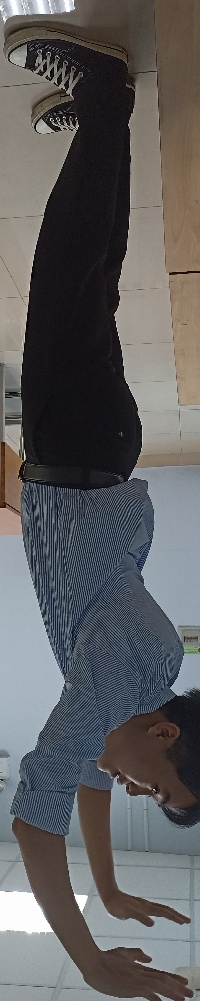

True label: Corpse - Predict label: Corpse


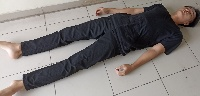

True label: Cresent Lunge - Predict label: Warrior One


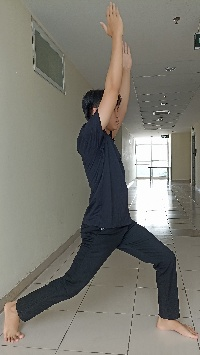

True label: Boat - Predict label: Boat


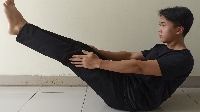

True label: Eagle - Predict label: Eagle


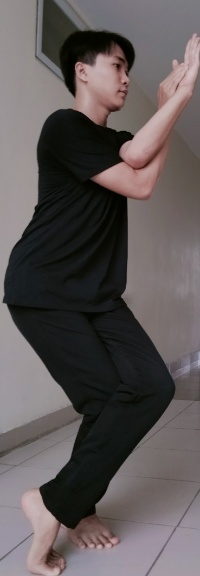

True label: Low Lunge - Predict label: Warrior One


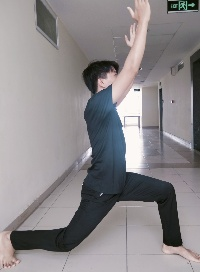

True label: Warrior Two - Predict label: Warrior Two


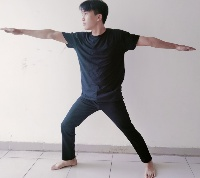

True label: Plank - Predict label: Plank


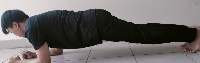

True label: Side Plank - Predict label: Side Plank


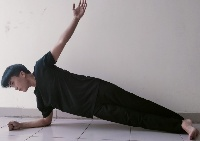

In [29]:
for img_name in os.listdir(os.path.join(dir_test,"directly_test")):
  label = img_name.split('.')[0]
  img_path = os.path.join(dir_test,"directly_test", img_name)

  for i in range(9):
    if label == labels[i]:
      print("True label: " + labels[i], end=" - ")
      print("Predict label: " + y_pred[i])
      cv2_imshow(cv2.imread(img_path))
      break